In [1]:
import glob
import numpy as np
import pandas as pd
import albumentations as A
import segmentation_models as sm

from dataset import Dataset
from dataset import visualize
from dataset import Dataloader
from dataset import denormalize
from keras.models import load_model
from segmentation_models.losses import DiceLoss
from segmentation_models.losses import CategoricalFocalLoss
from segmentation_models.metrics import IOUScore
from segmentation_models.metrics import FScore

2023-04-25 15:21:13.777348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `keras` framework.


<h2>efficientnetb3</h2>
<img width="80%" alt="efficientnetb3" src="figures/efficientnetb3.png">

In [2]:
CATEGORY_PATH = "dataset/category_id.txt"
TEST_PATH = "dataset/test/"
TEST_DIRS = glob.glob("dataset/test/*")

MODEL = "efficientnetb3"
CHECKPOINT_PATH = "checkpoints/" + MODEL + ".h5"
MODEL_PATH = "models/" + MODEL + ".h5"

In [3]:
def get_classes():
    categories = pd.read_csv(CATEGORY_PATH, sep="\t", names=["id", "name"])
    ids = categories["id"].to_list()
    classes = categories["name"].to_list()
    return ids, classes

In [4]:
def get_val_test_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [A.PadIfNeeded(384, 480)]
    return A.Compose(test_transform)

In [5]:
def get_preprocessing(preprocessing_fn):
    _transform = [A.Lambda(image=preprocessing_fn)]
    return A.Compose(_transform)

In [6]:
preprocess_input = sm.get_preprocessing(MODEL)

In [7]:
ids, classes = get_classes()

In [8]:
test_dataset = Dataset(TEST_PATH + "img", TEST_PATH + "mask", class_values=ids,
                       augmentation=get_val_test_augmentation(),
                       preprocessing=get_preprocessing(preprocess_input))

In [9]:
test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)
print(test_dataloader[0][0].shape)
print(test_dataloader[0][1].shape)

(1, 384, 480, 3)
(1, 384, 480, 13)


In [10]:
dice_loss = DiceLoss(class_weights=np.append(np.ones(12), 0.2))
focal_loss = CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
iou_score = IOUScore(threshold=0.5)
f1_score = FScore(threshold=0.5)

In [11]:
custom_objects = {
    "iou_score": iou_score,
    "f1-score": f1_score,
    "dice_loss_plus_1focal_loss": total_loss
}
model = load_model(CHECKPOINT_PATH, custom_objects=custom_objects)
print("Model Loaded")

2023-04-25 15:21:22.906409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model Loaded


In [12]:
test_score = model.evaluate_generator(test_dataloader)
print("Test Loss: ", test_score[0])
print("Test Mean IoU: ", test_score[1])
print("Test Mean F1: ", test_score[2])

/Users/hjj/opt/anaconda3/envs/nus-ncs-phishing/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


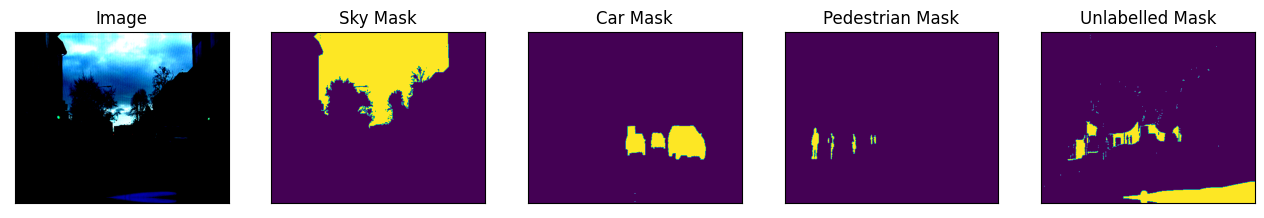

In [13]:
image, mask = test_dataset[0]
visualize(image=image,
          sky_mask=mask[..., 0].squeeze(),
          car_mask=mask[..., 8].squeeze(),
          pedestrian_mask=mask[..., 9].squeeze(),
          unlabelled_mask=mask[..., 11].squeeze())

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 3s 3s/step


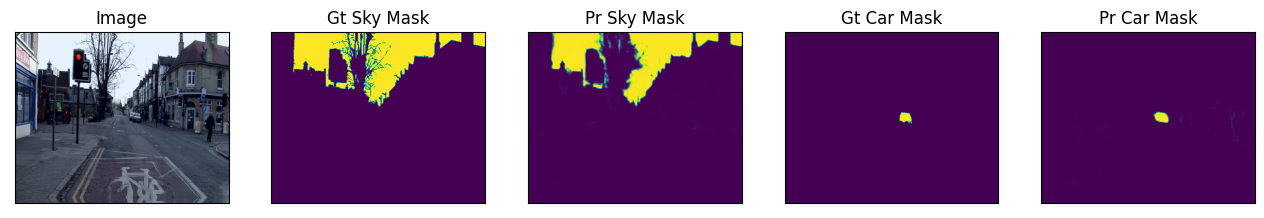

1/1 [==============================] - 0s 391ms/step


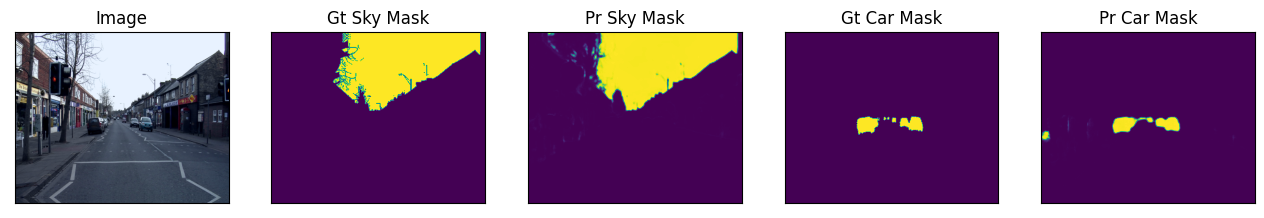

1/1 [==============================] - 0s 379ms/step


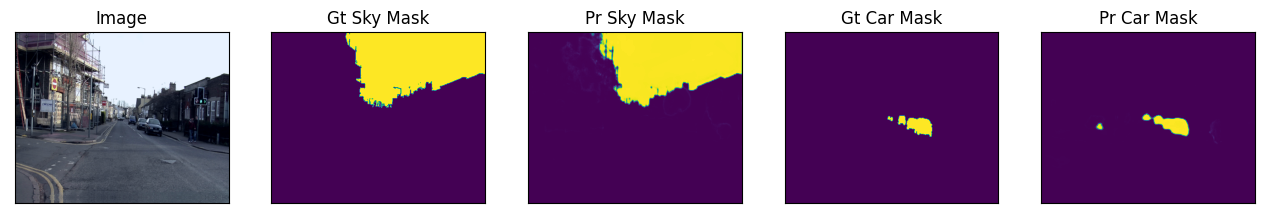

1/1 [==============================] - 0s 389ms/step


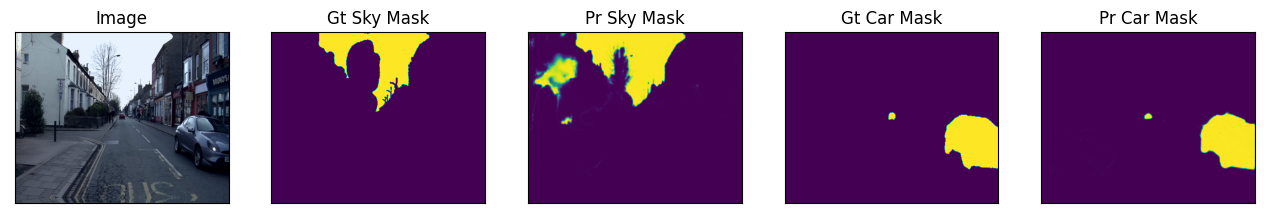

1/1 [==============================] - 0s 378ms/step


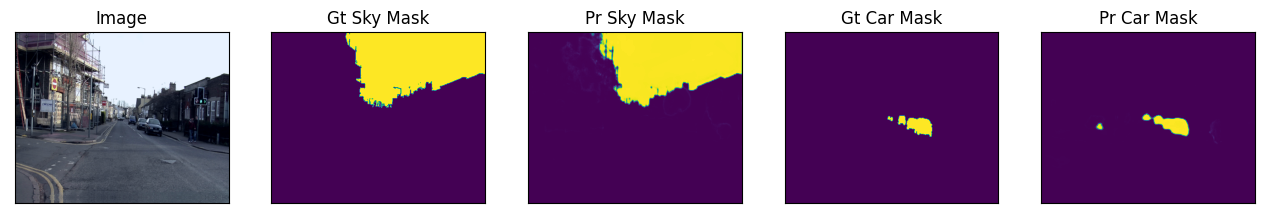

In [14]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)
for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    visualize(
        image=denormalize(image.squeeze()),
        gt_sky_mask=gt_mask[..., 0].squeeze(),
        pr_sky_mask=pr_mask[..., 0].squeeze(),
        gt_car_mask=gt_mask[..., 8].squeeze(),
        pr_car_mask=pr_mask[..., 8].squeeze())